In [1]:
import pandas as pd
import sys
import json
import LLDA.model.labeled_lda as llda
import numpy as np
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import jensenshannon

# sys.path.append('../')

In [2]:
with open('FRIS_data.json') as f:
    data = json.load(f)

clean_data = {}
for pro_id in data.keys():
    if data[pro_id]['publications'] and data[pro_id]['disciplines']:
        if 2 not in [len(disc) for disc in data[pro_id]['disciplines']]:
            clean_data[pro_id] = data[pro_id]
print(len(clean_data))

pro_dis_list = []
for pro_id in clean_data.keys():
    pro_dis_list.extend(clean_data[pro_id]['disciplines'])
pro_dis_set = set(pro_dis_list)

pub_dis_list = []
for pro_id in clean_data.keys():
    for pub_id in clean_data[pro_id]['publications'].keys():
        pub_dis_list.extend(clean_data[pro_id]['publications'][pub_id]['disciplines'])
pub_dis_set = set(pub_dis_list)

dis_set = pro_dis_set.intersection(pub_dis_set)

while not len(pro_dis_set) == len(pub_dis_set) == len(dis_set):
    pro_id_list = list(clean_data.keys())
    for pro_id in pro_id_list:
        if not set(clean_data[pro_id]['disciplines']).issubset(dis_set):
            del clean_data[pro_id]

    pro_id_list = list(clean_data.keys())
    for pro_id in pro_id_list:
        pubs = {}
        for pub_id in clean_data[pro_id]['publications'].keys():
            if clean_data[pro_id]['publications'][pub_id]['disciplines'] and clean_data[pro_id]['publications'][pub_id]['authors']:
                if set(clean_data[pro_id]['publications'][pub_id]['disciplines']).issubset(dis_set):
                    pubs[pub_id] = clean_data[pro_id]['publications'][pub_id]
        if pubs:
            clean_data[pro_id]['publications'] = pubs
        else:
            del clean_data[pro_id]
    print(len(clean_data))

    pro_dis_list = []
    for pro_id in clean_data.keys():
        pro_dis_list.extend(clean_data[pro_id]['disciplines'])
    pro_dis_set = set(pro_dis_list)

    pub_dis_list = []
    for pro_id in clean_data.keys():
        for pub_id in clean_data[pro_id]['publications'].keys():
            pub_dis_list.extend(clean_data[pro_id]['publications'][pub_id]['disciplines'])
    pub_dis_set = set(pub_dis_list)

    dis_set = pro_dis_set.intersection(pub_dis_set)

440
141
139
138
137


In [3]:
def get_unique_dis(data):
    disciplines = set()
    for pro_id in data.keys():
        disciplines.update(data[pro_id]['disciplines'])
    return disciplines
print(len(get_unique_dis(clean_data)))

dis_dict = {}
for dis in get_unique_dis(clean_data):
    dis_dict[dis] = []
for pro_id in clean_data.keys():
    for dis in clean_data[pro_id]['disciplines']:
        dis_dict[dis].append(pro_id)

pro_id_list = [dis_dict[dis][0] for dis in dis_dict.keys()]
sample_data = {pro_id: clean_data[pro_id] for pro_id in pro_id_list}
print(len(get_unique_dis(sample_data)))

pub_data = {}
for pro_id in sample_data.keys():
    for pub_id in sample_data[pro_id]['publications'].keys():
        pub_data[pub_id] = sample_data[pro_id]['publications'][pub_id]
print(len(get_unique_dis(pub_data)))

rest = set(clean_data.keys()) - set(sample_data.keys())
rest_data = {pro_id: clean_data[pro_id] for pro_id in rest}

dis_dict = {}
for dis in get_unique_dis(sample_data) - get_unique_dis(pub_data):
    dis_dict[dis] = []
for pro_id in rest_data.keys():
    dis_set = set()
    for pub in rest_data[pro_id]['publications'].values():
        dis_set = dis_set.union(set(pub['disciplines']))
    for dis in get_unique_dis(sample_data) - get_unique_dis(pub_data):
        if dis in dis_set:
            dis_dict[dis].append(pro_id)

pro_id_list = [dis_dict[dis][0] for dis in dis_dict.keys()]
sample_data.update({pro_id: clean_data[pro_id] for pro_id in pro_id_list})

pub_data = {}
for pro_id in sample_data.keys():
    for pub_id in sample_data[pro_id]['publications'].keys():
        pub_data[pub_id] = sample_data[pro_id]['publications'][pub_id]
print(len(get_unique_dis(pub_data)))
print(len(sample_data))

# select a sample of the data such that the sample has at least one project for each discipline
rest = set(clean_data.keys()) - set(sample_data.keys())
rest_data = {pro_id: clean_data[pro_id] for pro_id in rest}
num_test = int(0.25 * len(sample_data))

train_data = sample_data
test_data = {pro_id: clean_data[pro_id] for pro_id in list(rest_data.keys())[:num_test]}

train_project_data = {}
train_pub_data = []
for pro_id in train_data.keys():
    train_project_data[pro_id] = (train_data[pro_id]['abstract'], train_data[pro_id]['disciplines'])
    for pub_id in train_data[pro_id]['publications'].keys():
        train_pub_data.append((pub_id, train_data[pro_id]['publications'][pub_id]['abstract'], train_data[pro_id]['publications'][pub_id]['disciplines']))

test_project_data = {}
test_pub_data = []
for pro_id in test_data.keys():
    test_project_data[pro_id] = (test_data[pro_id]['abstract'], test_data[pro_id]['disciplines'])
    for pub_id in test_data[pro_id]['publications'].keys():
        test_pub_data.append((pub_id, test_data[pro_id]['publications'][pub_id]['abstract'], test_data[pro_id]['publications'][pub_id]['disciplines']))

print(len(train_project_data), len(train_pub_data))
print(len(test_project_data), len(test_pub_data))
print(len(get_unique_dis(train_data)), len(get_unique_dis({pub[0]: {'disciplines': pub[2]} for pub in train_pub_data})))

30
30
16
30
33
33 130
8 20
30 30


In [10]:
split = 0.95
train_data = {k: clean_data[k] for k in list(clean_data.keys())[:int(split*len(clean_data))]}
test_data = {k: clean_data[k] for k in list(clean_data.keys())[int(split*len(clean_data)):]}
print(len(train_data), len(test_data))

train_project_data = {}
train_pub_data = []
for pro_id in train_data.keys():
    train_project_data[pro_id] = (train_data[pro_id]['abstract'], train_data[pro_id]['disciplines'])
    for pub_id in train_data[pro_id]['publications'].keys():
        train_pub_data.append((pub_id, train_data[pro_id]['publications'][pub_id]['abstract'], train_data[pro_id]['publications'][pub_id]['disciplines']))

test_project_data = {}
test_pub_data = []
for pro_id in test_data.keys():
    test_project_data[pro_id] = (test_data[pro_id]['abstract'], test_data[pro_id]['disciplines'])
    for pub_id in test_data[pro_id]['publications'].keys():
        test_pub_data.append((pub_id, test_data[pro_id]['publications'][pub_id]['abstract'], test_data[pro_id]['publications'][pub_id]['disciplines']))

print(len(train_project_data), len(test_project_data), len(train_pub_data), len(test_pub_data))

130 7
130 7 411 77


In [11]:
print(train_project_data[list(train_project_data.keys())[0]])
print(train_pub_data[0][1])

('Viruses have evolved to hijack key cellular components of their natural host. The VirEOS project will analyze how medically relevant viruses such as human respiratory syncytial, hepatitis E, yellow fever, Zika or Kaposi sarcoma-associated herpes virus, interfere with RNA sensing and RNA homeostasis in their host cells. The impact of identified factors on the pathogenicity and on the immune responses will then be analyzed in vivo, using infectious models. Understanding how viruses manipulate cellular RNA should not only provide new targets to the development of antiviral drugs but also help to identify important cellular hubs in RNA physiology.', ['0106', '0301', '0302', '0306', 'common_topic', 'common_topic'])
Objective Chronic HBV/HDV infections are a major cause of liver cancer. Current treatments can only rarely eliminate HBV and HDV. Our previously developed preS1-HDAg immunotherapy could induce neutralising antibodies to HBV in vivo and raise HBV/HDV-specific T-cells. Here, we f

In [12]:
# # load from disk
# llda_model_project = llda.LldaModel()
# llda_model_project.load_model_from_dir("LLDA/data_models/pro_abstracts_disciplines", load_derivative_properties=False)
# print("llda_model_project", llda_model_project)
# # print("Top-5 terms of topic 'virus': ", llda_model_project.top_terms_of_topic("virus", 5, False))
# print("Doc-Topic Matrix: \n", llda_model_project.theta)
# print("Topic-Term Matrix: \n", llda_model_project.beta)

In [13]:
llda_model_project = llda.LldaModel(labeled_documents=train_project_data.values())
print(llda_model_project)
llda_model_pub = llda.LldaModel(labeled_documents=[(pub[1], pub[2]) for pub in train_pub_data])
print(llda_model_pub)


Labeled-LDA Model:
	K = 31
	M = 130
	T = 6184
	WN = 23044
	LN = 484
	alpha = 1.6129032258064515
	eta = 0.001
	perplexity = 602.7814227023401
	

Labeled-LDA Model:
	K = 31
	M = 411
	T = 15214
	WN = 80766
	LN = 1712
	alpha = 1.6129032258064515
	eta = 0.001
	perplexity = 1126.37270213414
	


In [7]:
# training
llda_model_project.training(iteration=10, log=True)
# while True:
#     print("iteration %s sampling..." % (llda_model.iteration + 1))
#     llda_model.training(1)
#     print("after iteration: %s, perplexity: %s" % (llda_model.iteration, llda_model.perplexity()))
#     print("delta beta: %s" % llda_model.delta_beta)
#     if llda_model.is_convergent(method="beta", delta=0.01):
#         break

after iteration: 0, perplexity: 600.1656335351732
gibbs sample count:  23044
after iteration: 1, perplexity: 513.2085312186566
gibbs sample count:  23044
after iteration: 2, perplexity: 506.3668869451031
gibbs sample count:  23044
after iteration: 3, perplexity: 507.019439535212
gibbs sample count:  23044
after iteration: 4, perplexity: 507.5340544441151
gibbs sample count:  23044
after iteration: 5, perplexity: 508.79570826203246
gibbs sample count:  23044
after iteration: 6, perplexity: 511.06896125421014
gibbs sample count:  23044
after iteration: 7, perplexity: 513.0552401379476
gibbs sample count:  23044
after iteration: 8, perplexity: 511.3655672605186
gibbs sample count:  23044
after iteration: 9, perplexity: 512.6641120524347
gibbs sample count:  23044


In [8]:
llda_model_pub.training(iteration=10, log=True)

after iteration: 0, perplexity: 1119.9225832220648
gibbs sample count:  80766
after iteration: 1, perplexity: 1014.9630329333584
gibbs sample count:  80766
after iteration: 2, perplexity: 994.648219767414
gibbs sample count:  80766
after iteration: 3, perplexity: 987.9275312431033
gibbs sample count:  80766
after iteration: 4, perplexity: 986.5645524925105
gibbs sample count:  80766
after iteration: 5, perplexity: 983.6531760987264
gibbs sample count:  80766
after iteration: 6, perplexity: 983.972614750165
gibbs sample count:  80766
after iteration: 7, perplexity: 980.7772266997846
gibbs sample count:  80766
after iteration: 8, perplexity: 982.6920427895129
gibbs sample count:  80766
after iteration: 9, perplexity: 981.9376293847236
gibbs sample count:  80766


In [9]:
# # update
# print("before updating: ", llda_model)
# update_labeled_documents = [("new example test example test example test example test", ["example", "test"])]
# llda_model.update(labeled_documents=update_labeled_documents)
# print("after updating: ", llda_model)

# # train again
# # llda_model.training(iteration=10, log=True)
# while True:
#     print("iteration %s sampling..." % (llda_model.iteration + 1))
#     llda_model.training(1)
#     print("after iteration: %s, perplexity: %s" % (llda_model.iteration, llda_model.perplexity()))
#     print("delta beta: %s" % llda_model.delta_beta)
#     if llda_model.is_convergent(method="beta", delta=0.01):
#         break

In [10]:
# inference
# note: the result topics may be different for difference training, because gibbs sampling is a random algorithm
document = list(test_project_data.values())[0][0]
print(document)

topics = llda_model_project.inference(document=document, iteration=100, times=10)
# print sorted topics
sorted(topics, key=lambda x: x[0])

To rationally design functional foods beyond basic nutrition, it is essential to develop an underpinning knowledge and understanding how food components and structures are transformed and absorbed during human digestion. This project aims to study the role of pectin - food component interactions in plant-based food systems and their consequence for food digestion. Pectin is an important structure-determining component in plant-based systems. To simulate the gastro-intestinal digestion, this project will use a standardized static in vitro digestion model.


[('0101', 0.014400921658986179),
 ('0102', 0.018865207373271894),
 ('0103', 0.043865207373271896),
 ('0104', 0.016186635944700465),
 ('0105', 0.017079493087557608),
 ('0106', 0.02600806451612904),
 ('0107', 0.016186635944700465),
 ('0201', 0.015293778801843322),
 ('0202', 0.015293778801843322),
 ('0203', 0.015293778801843322),
 ('0204', 0.015293778801843322),
 ('0205', 0.015293778801843322),
 ('0206', 0.02600806451612904),
 ('0207', 0.014400921658986179),
 ('0208', 0.018865207373271894),
 ('0299', 0.020650921658986177),
 ('0301', 0.0376152073732719),
 ('0302', 0.027793778801843323),
 ('0303', 0.02600806451612904),
 ('0304', 0.014400921658986179),
 ('0305', 0.014400921658986179),
 ('0306', 0.018865207373271894),
 ('0401', 0.020650921658986177),
 ('0402', 0.014400921658986179),
 ('0501', 0.018865207373271894),
 ('0502', 0.07422235023041476),
 ('0504', 0.015293778801843322),
 ('0505', 0.02868663594470047),
 ('0507', 0.015293778801843322),
 ('0604', 0.014400921658986179),
 ('common_topic',

In [11]:
documents = list(test_project_data.values())
project_matrix_test = np.zeros((len(documents), llda_model_project.K))

for i, (document, _) in enumerate(documents):
    topics = llda_model_project.inference(document=document, iteration=100, times=10)
    sorted_topics = sorted(topics, key=lambda x: x[0])
    for j, (topic, prob) in enumerate(sorted_topics):
        project_matrix_test[i, j] = prob

project_matrix_test

array([[0.01618664, 0.01618664, 0.01707949, 0.01886521, 0.01440092,
        0.03315092, 0.01707949, 0.01797235, 0.01529378, 0.01440092,
        0.01440092, 0.01440092, 0.02779378, 0.01440092, 0.01886521,
        0.02243664, 0.02243664, 0.02868664, 0.02690092, 0.01440092,
        0.01440092, 0.01707949, 0.01975806, 0.01618664, 0.01707949,
        0.07868664, 0.01440092, 0.06975806, 0.01618664, 0.01529378,
        0.33582949],
       [0.01409746, 0.01494852, 0.03282086, 0.0413315 , 0.0226081 ,
        0.04771448, 0.00771448, 0.00814001, 0.02643789, 0.00686342,
        0.01026767, 0.04473576, 0.00814001, 0.01026767, 0.01026767,
        0.00984214, 0.02175704, 0.01026767, 0.02941661, 0.00941661,
        0.01282086, 0.02048044, 0.0226081 , 0.00899108, 0.00941661,
        0.0319698 , 0.00984214, 0.00984214, 0.00984214, 0.01026767,
        0.46686342],
       [0.00989511, 0.00989511, 0.01848407, 0.02707303, 0.01541658,
        0.02645953, 0.0325945 , 0.01418959, 0.01480309, 0.01050861,
      

In [12]:
documents = [(pub[1], pub[2]) for pub in test_pub_data]
pub_matrix_test = np.zeros((len(documents), llda_model_pub.K))

for i, (document, _) in enumerate(documents):
    topics = llda_model_pub.inference(document=document, iteration=100, times=10)
    sorted_topics = sorted(topics, key=lambda x: x[0])
    for j, (topic, prob) in enumerate(sorted_topics):
        pub_matrix_test[i, j] = prob

pub_matrix_test

array([[0.01237386, 0.01493797, 0.01493797, ..., 0.01442514, 0.00878412,
        0.35698925],
       [0.00986001, 0.00646379, 0.02042605, ..., 0.00684114, 0.01061473,
        0.47740718],
       [0.0117468 , 0.01438831, 0.02080341, ..., 0.00872794, 0.01702982,
        0.43891662],
       ...,
       [0.02154183, 0.00911245, 0.06278476, ..., 0.01250228, 0.01363222,
        0.27351923],
       [0.01612903, 0.0094326 , 0.01791475, ..., 0.00853975, 0.01211118,
        0.39916475],
       [0.02817204, 0.02150538, 0.02817204, ..., 0.02550538, 0.02683871,
        0.06150538]])

In [13]:
# perplexity
# calculate perplexity on test data
perplexity = llda_model_project.perplexity(documents=map(lambda x: x[0], test_project_data),
                                   iteration=30,
                                   times=10)
print("perplexity on test data: %s" % perplexity)
# calculate perplexity on training data
print("perplexity on training data: %s" % llda_model_project.perplexity())

perplexity on test data: 52647.81800348594
perplexity on training data: 511.515465545758


In [14]:
# perplexity
# calculate perplexity on test data
perplexity = llda_model_pub.perplexity(documents=map(lambda x: x, [pub[1] for pub in test_pub_data]),
                                   iteration=30,
                                   times=10)
print("perplexity on test data: %s" % perplexity)
# calculate perplexity on training data
print("perplexity on training data: %s" % llda_model_pub.perplexity())

perplexity on test data: 1259.830684274202
perplexity on training data: 980.1651593995039


In [15]:
# save to disk
save_model_dir = "LLDA/data_models/topic_pro_dis_project"
# llda_model.save_model_to_dir(save_model_dir, save_derivative_properties=True)
llda_model_project.save_model_to_dir(save_model_dir)
# save to disk
save_model_dir = "LLDA/data_models/topic_pro_dis_pub"
# llda_model.save_model_to_dir(save_model_dir, save_derivative_properties=True)
llda_model_pub.save_model_to_dir(save_model_dir)

In [16]:
project_matrix = np.concatenate((llda_model_project.theta, project_matrix_test))
pub_matrix = np.concatenate((llda_model_pub.theta, pub_matrix_test))

distance_matrix = np.zeros((len(project_matrix), len(pub_matrix)))

for i in range(len(project_matrix)):
    for j in range(len(pub_matrix)):
        distance_matrix[i, j] = jensenshannon(project_matrix[i], pub_matrix[j])

In [17]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# create a dataframe with row indices as project ids and column indices as publication ids
# if publication is in project, then 1, else 0
# if publication date is before project start date, then 0, else 1
# ratio of intersection of organisations from project and publication to organisations from publication
# ratio of intersection of authors from project and publication to authors from publication

pub_data = []
for pro_id in clean_data.keys():
    for pub_id in clean_data[pro_id]['publications'].keys():
        pub_data.append((pub_id, clean_data[pro_id]['publications'][pub_id]))

data_matrix = [[0.] * len(pub_data) for _ in range(len(clean_data))]
for i, pro_id in enumerate(clean_data.keys()):
    for j, pub_id in enumerate([pub[0] for pub in pub_data]):
        belongs = 1 if pub_id in clean_data[pro_id]['publications'].keys() else 0
        date = 1 if clean_data[pro_id]['start_date'] <= pub_data[j][1]['date'] else 0
        org = len(set(clean_data[pro_id]['organizations']) & set(pub_data[j][1]['organizations'])) / len(set(pub_data[j][1]['organizations']))
        auth = len(set(clean_data[pro_id]['authors']) & set(pub_data[j][1]['authors'])) / len(set(pub_data[j][1]['organizations']))
        distance = distance_matrix[i, j]
        data_matrix[i][j] = [belongs, date, org, auth, distance]

df = pd.DataFrame(data_matrix, index=clean_data.keys(), columns=[pub[0] for pub in pub_data])
df.to_csv('xgb_data_pro_dis.csv')
df.head()

,55975b31-3cc2-4534-a097-85b1eab6cd53,bbaf834d-f8e1-4187-84b4-a35484625c09,50ad741e-6c36-4fbb-9b48-0fa901e9f63b,383f820f-0e0c-4aee-bfb4-6ebd5f6c2b63,ca3fcf40-66cf-44cd-a51e-3cff9e189cf5,d0399103-8325-4b32-9476-3d3729793829,ae73aff3-91db-470d-bc96-ea6d2e9fe137,d640f97c-94eb-4330-9772-f19d23865d19,db848229-540e-455a-baf4-55a73676b869,8a4dc512-1865-45f1-90d6-aeb015495ac1,9674c6a9-f18f-4d91-aa5b-a2b8529240f3,accad675-6a0f-41fb-b620-980e0881a4f0,a83f4646-d3ec-4054-bb10-23cfc88faba0,b1aff172-e1e8-4606-96ba-2d404a13ff95,16f7a1da-ab4f-4597-8ec6-7f96910d0acb,9c7e1f16-6a1c-4de1-ad85-647644566623,564429ef-c14c-403c-a873-edd6ecd1b2a1,2bd01a38-c1e9-4ad5-8e8f-b8e5ac780ecd,178aa060-8c9e-482d-9116-eb0dac9beab7,5fdca7f9-be14-45ea-ac81-e8eef803c17f,2f5b49e5-1de0-472e-87dd-75a6538be19a,27a70ef5-45ca-4ca7-922e-76870cf74f37,28d65a5e-961a-4c55-9969-5003a6eddabd,147e4591-dd7b-40c0-83fc-5b7ba35f0225,d1e966b3-e709-46f5-a250-70acd89aea99,e420d00e-6cec-4147-94dc-d5d0cddd4b18,9951ea23-c2ed-449e-adac-a7fb0bf29dc2,9d5ef35f-cfd1-462d-91b3-95b3eb3d619c,53455db9-c541-4dc1-8d61-d15d38ef0b2c,940fecb7-be24-4f2a-bdbc-6be9b8bc9aaf,d85582fd-b9a9-4cc8-a043-d6f192db8cb9,00ee9344-2335-45a3-8b28-845d7060e950,a12d4c59-161d-4d4c-9d07-156a61944bb8,0b375ea2-3895-425b-af6c-13d6114dfc61,08afc51d-244a-46e0-b23c-f45b2ace35b1,03242d2a-5e3e-4d68-96fd-ad8535701084,029db07d-e65f-44c7-ae4a-95e00dfbdfc1,0594ab2b-78a0-423d-9171-033a13b1e887,b499f5f4-d7ee-4def-8b3c-e2c112bccf5b,c69a60aa-91b9-4bbd-9c6d-49ad202fd372,c5f0240f-c092-46a8-b855-31a7c08ca274,c09b5266-fc94-417e-9045-f251468bad71,4491c57b-ca46-4a89-92e1-78d0e2601aad,41bc68db-6101-4af6-90fd-8a5ef588d97d,448f38ee-7946-4d17-bd1b-a4e2a4a369d5,9269609a-d6f1-4775-bb7e-a2299555ccf6,4649f15a-a650-485a-8ba6-ff61cd98ebd2,bf59e0ca-6a22-4a04-af52-f3480c586417,e7cf6eb8-dc55-428e-b19e-c0f87173d805,f613b755-3ec7-4e75-bc11-44463cb8f0ec,b61d5a70-03be-4e2f-aa25-7fe3247117df,076f5970-29f6-4d05-98c9-0ab46bb57ab6,fe9233d2-0478-4133-86c2-6d0796371d4d,61003419-dfc3-406e-bcca-46a771393125,13bdf954-8619-475f-a56e-ea24c7703693,d80decf7-494c-44e7-9172-15ff30b1ccda,1b38b0aa-84a4-4cfc-869f-bef2c95a1f4e,fdfe147e-40c5-437c-8143-97fe6a1c134a,3bf7f8c6-134e-4c7c-ab35-4147e26001e1,6ff0e4d3-e9d0-4327-ac45-22ddcda95357,5342abe2-77e2-4938-8483-4705d684e82d,758f7459-c689-430a-acc9-ef65e036c00f,9d50ee56-a605-4695-8211-d216f8165e88,501a5725-bf6c-4a80-9b48-a63a13cdefc2,51b1ff42-1741-4433-b60b-3e8709f4d645,51b1ff42-1741-4433-b60b-3e8709f4d645,3b59ee19-4874-4bb1-a6da-76a56654510e,0700ea19-4355-4346-af47-bf18a9c6b95e,c7d0ae51-37c0-4c7f-b2f4-dda30aaa213a,9e27a031-0a8c-4221-a4d0-7c8a9e6f121e,72fe1ec0-8a1d-499a-99b3-b25ca20364f8,c4d40890-cf1d-4a47-a304-cb017422b092,d567f5ca-a157-4392-8cd8-592aa8b46e1b,cf32d3e0-e59e-4ee0-b634-9fe34d94225c,bf1bf73b-3288-4f77-9d80-ab5540d31175,2388cc8b-5498-493e-a981-b4971bdff594,8dcd5398-eded-4d26-b016-9e116415758e,7cec9636-8bd1-4e05-8364-49c4a510d66b,0b9e20fa-3c4f-4794-a523-39e387ae2add,9d0401df-4f47-4a7d-b206-2b85ccb689e5,26095ab4-5a23-4520-a7c7-ffa9f1baf8f7,3b2990be-de1d-42c3-97f8-7ef613886b66,49462a4e-b17f-4623-8126-bb9a943da64d,7fc06894-0853-4fd2-9405-bad8eee7a526,23c1e09f-06ee-490c-9876-5d7b1d0443c9,7802b19e-badf-464a-a1de-98dfd2f626dc,7c791d1b-64fe-4de6-bd4a-588afec58b3b,2b96e9d4-4476-46e1-b8f8-a8da539e8b36,f3ded410-889c-434e-a39e-65d0d01ef89f,1f7d1e6c-4c90-48c0-a22b-64f3eb3db4b3,d7e1ae59-e05c-4bbe-8da1-e7baee6e2cc6,ccae2f71-316a-4fe8-9eb4-20b2961cd0c5,a6d0c494-e5ba-4289-a492-3e4d50e99fd8,881614c1-d9f0-463f-80b9-f7807be6b992,2c0cf738-0c09-415c-a3ae-b1dd9f158f31,ccfedabd-6706-423e-a82c-508b6852e9fc,756fee77-b592-440d-a5af-ffdbae2875dc,0b420ec7-d100-41f9-8393-5a9b1ca234f2,1aac2b7c-6e65-4a0c-9336-d08499ceec17,f61b8ffc-d202-4eb2-b534-9d7e3f0b7f03,7169dab6-b3a7-4ce7-808b-8e629c293d92,e9cafd4f-8206-453e-9b3c-938536d7d7ce,fe1ad4b0-05c4-47a9-8213-a4f32867afd9,7b29ef7d-af98-4928-801d-b11b16a09b21,943250c6-32fc-43d0-abf4-720d1b63d621,62e91f72-01f6-43db-9b73-d421a028b355,a0001e6f-f911-4ffe-909f-582f42d32da0,105bfbb6-c169-4383-aaa8-3d0404b22b8a,b3c

In [18]:
# gradient boosting
# data matrix is constructed as follows: rows are projects, columns are publications
# each cell is a list of 5 elements: [belongs, date, org, auth, distance]
# outcome is whether publication is in project or not
# features are date, org, auth, distance

import xgboost as xgb
from xgboost import plot_importance
import matplotlib.pylab as plt

In [19]:
gb_raw_shape = (df.shape[0], df.shape[1], len(df.iloc[0, 0]))
print(gb_raw_shape)

gb_data = []
for i in range(len(list(df))):
    gb_data.extend(df.iloc[:, i].values.tolist())
gb_data = np.array(gb_data)
print(gb_data.shape)

project_numbers = np.array(list(range(1, gb_raw_shape[0] + 1)) * gb_raw_shape[1]).reshape(-1, 1)
gb_data = np.hstack((gb_data, project_numbers))
gb_data

(137, 488, 5)
(66856, 5)


array([[  1.        ,   1.        ,   0.        ,   1.        ,
          0.24118624,   1.        ],
       [  0.        ,   1.        ,   0.        ,   0.        ,
          0.6149756 ,   2.        ],
       [  0.        ,   1.        ,   0.        ,   0.        ,
          0.46934232,   3.        ],
       ...,
       [  0.        ,   1.        ,   0.        ,   0.        ,
          0.37274355, 135.        ],
       [  0.        ,   1.        ,   0.        ,   0.        ,
          0.46345884, 136.        ],
       [  1.        ,   1.        ,   1.        ,   0.        ,
          0.39636356, 137.        ]])

In [20]:
X = gb_data[:, 1:]
y = gb_data[:, 0]

split = len(train_pub_data) * len(clean_data)
X_train = X[:split]
X_test = X[split:]
y_train = y[:split]
y_test = y[split:]

In [21]:
params = {
    'objective': 'binary:logistic',
    'max_depth': 3,
    'learning_rate': 0.01
}

# params_constrained = params.copy()
# params_constrained['interaction_constraints'] = '[[0, 1, 2, 3, 4]]'
feature_names = ['date criterion', 'organisation ratio', 'author ratio', 'distance', 'project number']
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=feature_names)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=feature_names)

num_boost_round = 10000
xgb_model = xgb.train(params, 
                      dtrain, 
                      num_boost_round,
                      evals=[(dtest, 'test')],
                      early_stopping_rounds=200, 
                      verbose_eval=100)

[0]	test-logloss:0.68334
[100]	test-logloss:0.20815
[200]	test-logloss:0.07836
[300]	test-logloss:0.03399
[400]	test-logloss:0.01756
[500]	test-logloss:0.01118
[600]	test-logloss:0.00854
[700]	test-logloss:0.00690
[800]	test-logloss:0.00580
[900]	test-logloss:0.00542
[1000]	test-logloss:0.00516
[1100]	test-logloss:0.00488
[1200]	test-logloss:0.00481
[1300]	test-logloss:0.00480
[1400]	test-logloss:0.00484
[1500]	test-logloss:0.00476
[1600]	test-logloss:0.00465
[1700]	test-logloss:0.00456
[1800]	test-logloss:0.00454
[1900]	test-logloss:0.00439
[2000]	test-logloss:0.00431
[2100]	test-logloss:0.00432
[2200]	test-logloss:0.00438
[2300]	test-logloss:0.00434
[2400]	test-logloss:0.00428
[2500]	test-logloss:0.00422
[2600]	test-logloss:0.00414
[2700]	test-logloss:0.00406
[2800]	test-logloss:0.00403
[2900]	test-logloss:0.00404
[3000]	test-logloss:0.00409
[3100]	test-logloss:0.00410
[3200]	test-logloss:0.00410
[3300]	test-logloss:0.00408
[3400]	test-logloss:0.00405
[3500]	test-logloss:0.00405
[360

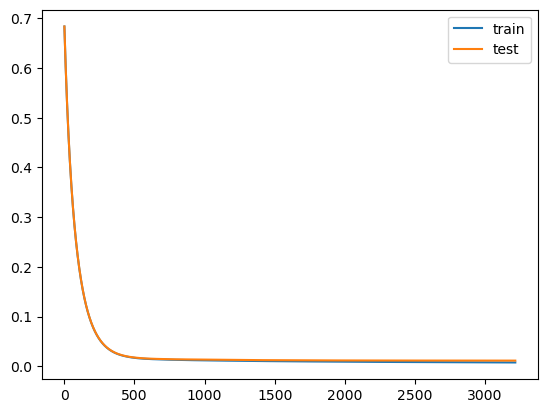

In [22]:
xgb_cv = xgb.cv(params,
                dtrain,
                num_boost_round=num_boost_round,
                nfold=5,
                early_stopping_rounds=200)

# plot xgb_cv
fig, ax = plt.subplots()
ax.plot(xgb_cv['train-logloss-mean'], label='train')
ax.plot(xgb_cv['test-logloss-mean'], label='test')
ax.legend()

In [23]:
# make prediction
y_pred = xgb_model.predict(dtest)

# get the projects for highest 3 predictions for each publication
project_numbers_pred = []
for i in range(0, len(y_pred), gb_raw_shape[0]):
    project_numbers_pred.append(list(np.argsort(y_pred[i:i+gb_raw_shape[0]]) + 1)[::-1][:3])

project_lists = []
for i in range(0, gb_data.shape[0], gb_raw_shape[0]):
    pub_belongs = gb_data[i:i + gb_raw_shape[0], 0] * gb_data[i:i + gb_raw_shape[0], -1]
    project = sorted(list(pub_belongs[pub_belongs != 0].astype(int)), reverse=True)
    project_lists.append(project)
project_lists_test = project_lists[len(train_pub_data):]

# calculate accuracy
accuracy_list = []
for i, project_list in enumerate(list(project_lists_test)):
    ratio = len(set(project_numbers_pred[i]) & set(project_list)) / len(set(project_list))
    accuracy_list.append(ratio)

accuracy = sum(accuracy_list) / len(accuracy_list)
print(accuracy)

# get indices of accuracy_list different than 1
indices = [i for i, x in enumerate(accuracy_list) if x != 1]
print(indices)
print([project_numbers_pred[i] for i in indices])
print([project_lists_test[i] for i in indices])

1.0
[]
[]
[]


In [24]:
# make two predictions for each publication
y_pred = xgb_model.predict(dtest)

# get the projects for the highest prediction for each publication
project_numbers_pred = []
for i in range(0, len(y_pred), gb_raw_shape[0]):
    project_numbers_pred.append(list(np.argsort(y_pred[i:i+gb_raw_shape[0]]) + 1)[::-1][:2])

project_lists = []
for i in range(0, gb_data.shape[0], gb_raw_shape[0]):
    pub_belongs = gb_data[i:i + gb_raw_shape[0], 0] * gb_data[i:i + gb_raw_shape[0], -1]
    project = sorted(list(pub_belongs[pub_belongs != 0].astype(int)), reverse=True)
    project_lists.append(project)

project_lists_test = project_lists[len(train_pub_data):]

# calculate accuracy
# use y_test as mask for project_numbers_test
accuracy_list = []
for i, project_list in enumerate(list(project_lists_test)):
    ratio = len(set(project_numbers_pred[i]) & set(project_list)) / len(set(project_list))
    accuracy_list.append(ratio)

accuracy = sum(accuracy_list) / len(accuracy_list)
print(accuracy)

1.0


In [25]:
# make single prediction for each publication
y_pred = xgb_model.predict(dtest)

# get the projects for the highest prediction for each publication
project_numbers_pred = []
for i in range(0, len(y_pred), gb_raw_shape[0]):
    project_numbers_pred.append(list(np.argsort(y_pred[i:i+gb_raw_shape[0]]) + 1)[::-1][:1])

project_lists = []
for i in range(0, gb_data.shape[0], gb_raw_shape[0]):
    pub_belongs = gb_data[i:i + gb_raw_shape[0], 0] * gb_data[i:i + gb_raw_shape[0], -1]
    project = sorted(list(pub_belongs[pub_belongs != 0].astype(int)), reverse=True)
    project_lists.append(project)

project_lists_test = project_lists[len(train_pub_data):]

# calculate accuracy
accuracy_list = []
for i, project_list in enumerate(list(project_lists_test)):
    accuracy = 1 if project_numbers_pred[i][0] in project_list else 0
    accuracy_list.append(accuracy)

accuracy = sum(accuracy_list) / len(accuracy_list)
print(accuracy)

0.961038961038961


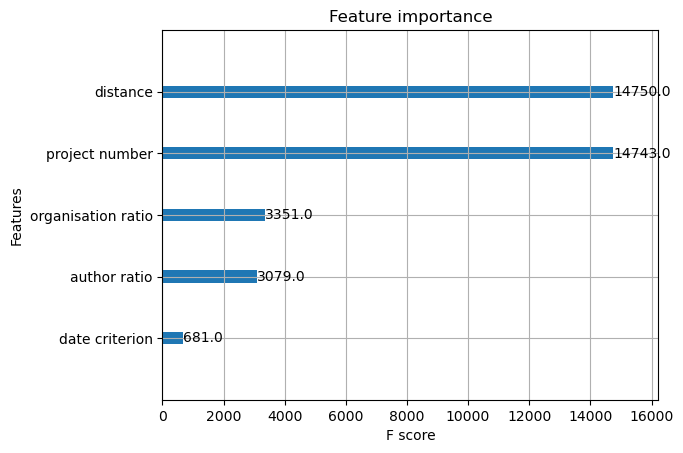

In [26]:
plot_importance(xgb_model)
plt.show()

[0]	test-logloss:0.59954
[100]	test-logloss:0.00541
[200]	test-logloss:0.00438
[300]	test-logloss:0.00361
[400]	test-logloss:0.00328
[500]	test-logloss:0.00328
[600]	test-logloss:0.00349
[700]	test-logloss:0.00388
[800]	test-logloss:0.00404
[900]	test-logloss:0.00424
[1000]	test-logloss:0.00449
[1100]	test-logloss:0.00457
[1200]	test-logloss:0.00448
[1300]	test-logloss:0.00454
[1400]	test-logloss:0.00470
[1432]	test-logloss:0.00477
1.0


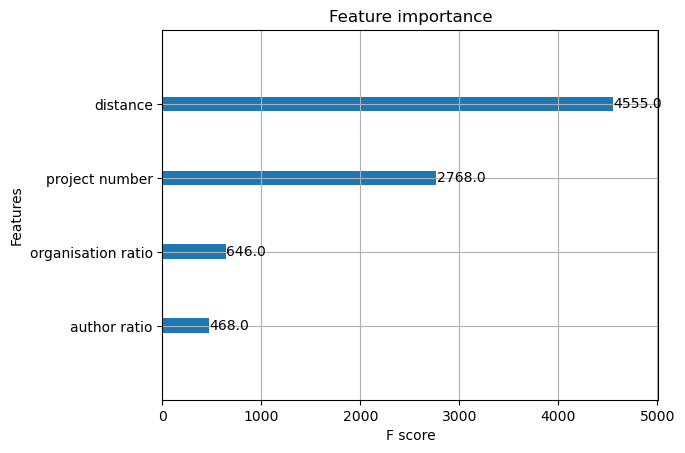

In [27]:
# drop auth column
gb_data_no_date = np.delete(gb_data, 1, 1)

X = gb_data_no_date[:, 1:]
y = gb_data_no_date[:, 0]

X_train = X[:split]
X_test = X[split:]
y_train = y[:split]
y_test = y[split:]

params = {
    'objective': 'binary:logistic',
    'max_depth': 3,
    'learning_rate': 0.1
}

# params_constrained = params.copy()
# params_constrained['interaction_constraints'] = '[[0, 1, 2, 3]]'
feature_names = ['organisation ratio', 'author ratio', 'distance', 'project number']
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=feature_names, enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=feature_names, enable_categorical=True)

num_boost_round = 10000
xgb_model = xgb.train(params, 
                      dtrain, 
                      num_boost_round, 
                      evals=[(dtest, 'test')], 
                      early_stopping_rounds=1000, 
                      verbose_eval=100)

# make three predictions for each publication
y_pred = xgb_model.predict(dtest)

# get the projects for the highest prediction for each publication
project_numbers_pred = []
for i in range(0, len(y_pred), gb_raw_shape[0]):
    project_numbers_pred.append(list(np.argsort(y_pred[i:i+gb_raw_shape[0]]) + 1)[::-1][:3])

project_lists = []
for i in range(0, gb_data.shape[0], gb_raw_shape[0]):
    pub_belongs = gb_data[i:i + gb_raw_shape[0], 0] * gb_data[i:i + gb_raw_shape[0], -1]
    project = sorted(list(pub_belongs[pub_belongs != 0].astype(int)), reverse=True)
    project_lists.append(project)

project_lists_test = project_lists[len(train_pub_data):]

# calculate accuracy
# use y_test as mask for project_numbers_test
accuracy_list = []
for i, project_list in enumerate(list(project_lists_test)):
    ratio = len(set(project_numbers_pred[i]) & set(project_list)) / len(set(project_list))
    accuracy_list.append(ratio)

accuracy = sum(accuracy_list) / len(accuracy_list)
print(accuracy)

plot_importance(xgb_model)
plt.show()